# STACKING ENSEMBLE REGRESSION

In [8]:
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Thư viện cho Stacking
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression

# Thêm thư mục gốc vào path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
import warnings
warnings.filterwarnings('ignore')

from src.utils import load_data, save_model, save_metrics, evaluate, save_figure

# Chuyển CWD về thư mục gốc nếu đang ở thư mục notebooks
try:
    if Path(os.getcwd()).name == 'notebooks':
        os.chdir('..')
except:
    pass


# 1. LOAD DỮ LIỆU VÀ MODELS ĐÃ TUNE

In [11]:
# Load data
X, y = load_data()
print(f"Data loaded. Shape: {X.shape}")

# Hàm load model 
def load_tuned_model(name):
    try:
        model = joblib.load(f'models/{name}.pkl')
        print(f"- Đã load model: {name}")
        return model
    except FileNotFoundError:
        print(f" Không tìm thấy file models/{name}.pkl. Vui lòng chạy notebook tuning trước.")
        return None

# Load các base models
ridge_model = load_tuned_model('ridge')
xgboost_model = load_tuned_model('xgboost')
rf_model = load_tuned_model('random_forest')
lgb_model = load_tuned_model('lightgbm')
linear_model = load_tuned_model('linear')    

# Danh sách các model hợp lệ
base_models_list = [m for m in [ridge_model, xgboost_model, rf_model, lgb_model, linear_model] if m is not None]

if len(base_models_list) < 2:
    print("Cần ít nhất 2 model để thực hiện Stacking hiệu quả!")


Data loaded. Shape: (1458, 338)
- Đã load model: ridge
- Đã load model: xgboost
- Đã load model: random_forest
- Đã load model: lightgbm
- Đã load model: linear


# 2. ĐỊNH NGHĨA CLASS StackingAveragedModels

In [12]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        X_arr = np.array(X)
        y_arr = np.array(y)

        out_of_fold_predictions = np.zeros((X_arr.shape[0], len(self.base_models)))

        for i, model in enumerate(self.base_models):
            for train_idx, holdout_idx in kfold.split(X_arr, y_arr):
                instance = clone(model)
                self.base_models_[i].append(instance)

                instance.fit(X_arr[train_idx], y_arr[train_idx])

                y_pred = instance.predict(X_arr[holdout_idx])
                out_of_fold_predictions[holdout_idx, i] = y_pred

        self.meta_model_.fit(out_of_fold_predictions, y_arr)
        self.oof_predictions_ = out_of_fold_predictions
        return self
    
    def predict(self, X):
        X_arr = np.array(X)

        meta_features = np.column_stack([
            np.column_stack([model.predict(X_arr) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])

        return self.meta_model_.predict(meta_features)


# 3. Khởi Tạo và Huấn Luyện Stacking Model
Sử dụng **Ridge** làm Meta-Model.

In [13]:
meta_learner = Ridge(alpha=10.0)

print("-" * 66)
print("\t\t     Khởi tạo Stacking Model")
print("-" * 66)
print(f"Base Models: {[type(m).__name__ for m in base_models_list]}")
print(f"Meta Model: {type(meta_learner).__name__}")

stacking_model = StackingAveragedModels(
    base_models=base_models_list,
    meta_model=meta_learner,
    n_folds=5
)

print("Đang tính toán Cross-Validation Score...")
cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f"Stacking CV RMSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("Đang huấn luyện mô hình Stacking trên toàn bộ dữ liệu...")
stacking_model.fit(X, y)
print("Huấn luyện hoàn tất.")


------------------------------------------------------------------
		     Khởi tạo Stacking Model
------------------------------------------------------------------
Base Models: ['Ridge', 'XGBRegressor', 'RandomForestRegressor', 'LGBMRegressor', 'LinearRegression']
Meta Model: Ridge
Đang tính toán Cross-Validation Score...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-

Stacking CV RMSE: 0.1120 (+/- 0.0065)
Đang huấn luyện mô hình Stacking trên toàn bộ dữ liệu...
Huấn luyện hoàn tất.


# 4. ĐÁNH GIÁ VÀ LƯU KẾT QUẢ 

In [14]:
y_pred_stack_oof = stacking_model.meta_model_.predict(stacking_model.oof_predictions_)

metrics = evaluate(y, y_pred_stack_oof)

print("\n STACKING ENSEMBLE Metrics (OOF)")
print("-" * 30)
for k, v in metrics.items():
    print(f"  - {k.upper()}: {v:.4f}")
print("-" * 30)

model_name = "stacking_ensemble"
save_model(stacking_model, model_name)
save_metrics("stacking_ensemble", metrics)

print("Kết quả đã được lưu vào results/metrics.json")



 STACKING ENSEMBLE Metrics (OOF)
------------------------------
  - RMSE: 0.1124
  - MAE: 0.0761
  - R2: 0.9209
------------------------------
Kết quả đã được lưu vào results/metrics.json


# 5. TRỰC QUAN HÓA KẾT QUẢ 

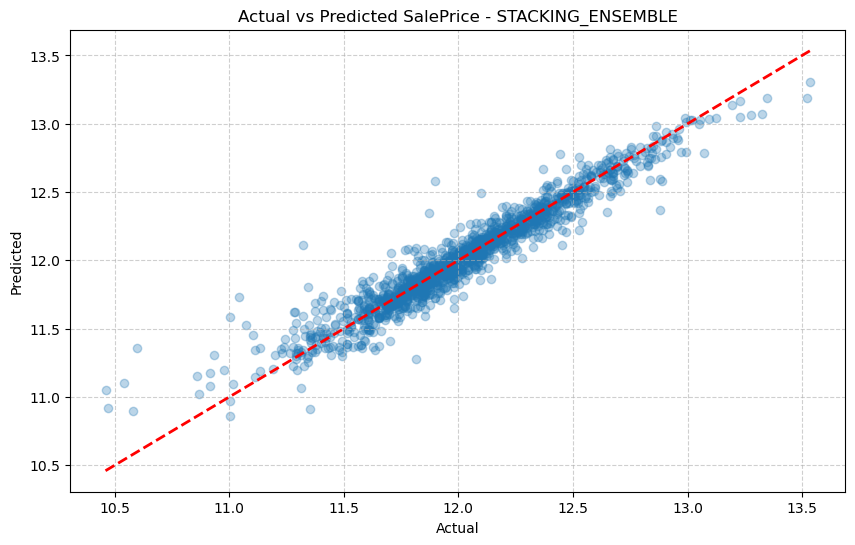

Hình ảnh đã lưu thành công tại: results/figures/stacking_model_actual_vs_predicted.png


Exception ignored in: <function ResourceTracker.__del__ at 0x104d21e40>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104255e40>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106861e40>
Traceback (most recent call last

In [16]:
filename_to_save = 'stacking_model_actual_vs_predicted.png' 
figure_path = f'results/figures/{filename_to_save}' 

fig, ax = plt.subplots(figsize=(10, 6)) 

ax.scatter(y, y_pred_stack_oof, alpha=0.3)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title(f'Actual vs Predicted SalePrice - {model_name.upper()}')
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()
save_figure(fig, filename=filename_to_save) 



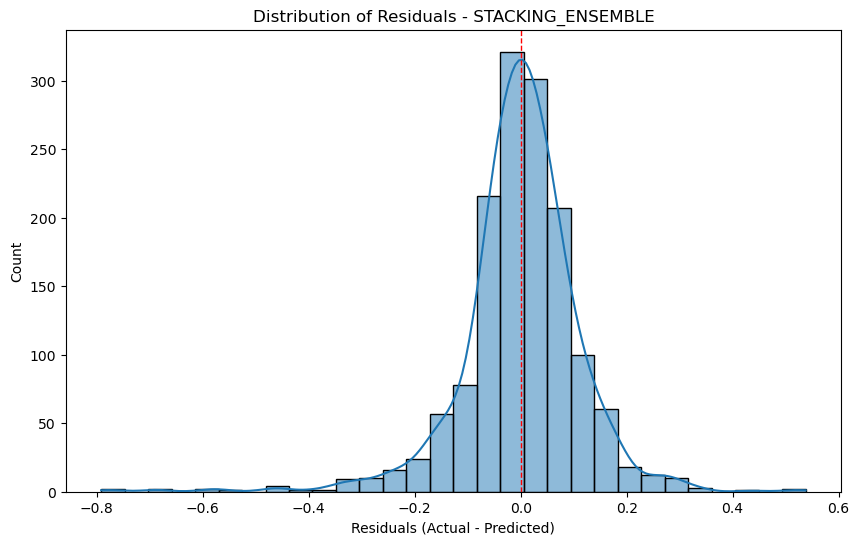

Hình ảnh đã lưu thành công tại: results/figures/stacking_model_actual_vs_predicted.png


In [15]:
residuals = y - y_pred_stack_oof
figure_path_res = 'results/figures/stacking_model_residuals.png'

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title(f'Distribution of Residuals - {model_name.upper()}')
plt.savefig(figure_path_res)
plt.show()

save_figure(fig, filename=filename_to_save) 